In [1]:
def add_src_and_logger(is_renkolab, save_dir):
    import sys
    from pathlib import Path
    import os
    import logging 
    src_path = Path.home() / "work" / "fco2diffusion" / "src"
    if str(src_path) not in sys.path:
        sys.path.insert(0, str(src_path))

    if is_renkolab:
        DATA_PATH = '/home/jovyan/work/datapolybox/'
    else:
        DATA_PATH = '../data/training_data/'
    
    if (save_dir is not None) and (not os.path.exists(save_dir)):
        os.makedirs(save_dir)

    if save_dir is None:
        logging.basicConfig(
            level=logging.INFO, 
            format='%(asctime)s - %(levelname)s - %(message)s'
            )
    else:
        logging.basicConfig(
            filename=save_dir+'training.log',
            filemode='a',
            level=logging.INFO, 
            format='%(asctime)s - %(levelname)s - %(message)s'
            )
    return DATA_PATH, logging

is_renkolab = False
save_dir = None
DATA_PATH, logger = add_src_and_logger(is_renkolab, save_dir)

In [2]:
import pandas as pd
import numpy as np
from fco2models.utraining import prepare_segment_ds, prep_df
val_df = pd.read_parquet(DATA_PATH+'valdf_100km_xco2.pq')
val_df2021 = pd.read_parquet(DATA_PATH+'df_100km_xco2_2021.pq')
train_df = pd.read_parquet(DATA_PATH+'traindf_100km_xco2.pq')

train_df, val_df, val_df2021 = prep_df([train_df, val_df, val_df2021], bound=True, index=['segment', 'bin'])


2025-05-06 14:58:39,775 - INFO - salinity stacking
2025-05-06 14:58:40,076 - INFO - adding positional and temporal encodings
2025-05-06 14:58:44,442 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-05-06 14:58:44,626 - INFO - add climatology data
2025-05-06 14:59:12,876 - INFO - replacing outliers with Nans, fco2rec_uatm > 400
2025-05-06 14:59:13,943 - INFO - salinity stacking
2025-05-06 14:59:14,026 - INFO - adding positional and temporal encodings
2025-05-06 14:59:14,448 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-05-06 14:59:14,526 - INFO - add climatology data
2025-05-06 14:59:25,917 - INFO - replacing outliers with Nans, fco2rec_uatm > 400
2025-05-06 14:59:26,061 - INFO - salinity stacking
2025-05-06 14:59:26,093 - INFO - adding positional and temporal encodings
2025-05-06 14:59:26,260 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-05-06 14:59:26,280 - INFO - add climatology data
2025-05-06 14:59:35,826 - INFO - replacing outlier

In [3]:
def ad_hoc_stuff(df):
    # df['fco2rec_uatm'] += df['xco2']
    # df['fco2rec_uatm'] = df['fco2rec_uatm'].clip(None, 500)
    # clip between 5th and 95th percentile
    df['fco2rec_uatm'] = df['fco2rec_uatm'].clip(df['fco2rec_uatm'].quantile(0.05), df['fco2rec_uatm'].quantile(0.95))
    return df


# train_df = ad_hoc_stuff(train_df)
# val_df = ad_hoc_stuff(val_df)
# val_df2021 = ad_hoc_stuff(val_df2021)
    

In [4]:
from diffusers import DDPMScheduler, UNet1DModel
from fco2models.models import MLP, UNet2DModelWrapper
import torch
import json
from fco2models.ueval import load_model

# load model
save_path = '../models/renko/co2clim/naive_pos/'
model_path = 'e_80.pt'
model_class = UNet2DModelWrapper


model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class, training_complete=False)
print("Model loaded")

Model loaded


In [5]:
params['predictors']

['sst_cci',
 'sss_cci',
 'chl_globcolour',
 'ssh_sla',
 'mld_dens_soda',
 'xco2',
 'co2_clim8d',
 'sin_day_of_year',
 'cos_day_of_year',
 'sin_lat',
 'sin_lon_cos_lat',
 'cos_lon_cos_lat']

In [6]:
from fco2models.utraining import prepare_segment_ds, normalize_dss, get_stats
predictors = params['predictors']
#predictors = ['sst_cci', 'sss_cci', 'chl_globcolour', 'day_of_year']
info = ['lat', 'lon', 'day_of_year', 'year', 'expocode']
(train_ds, train_coords), (val_ds, val_coords) = prepare_segment_ds([train_df, val_df], predictors, info=info)
#np.random.shuffle(val_ds) # val_coord ARE NO LONGER VALID IF YOU SHUFFLE val_ds_norm
train_stats = get_stats(train_ds)
# np.random.shuffle(np.concatenate([val_ds, val_coords], axis=1))
# print(val_ds[0, 0, :])
# print(val_coords[0, 0, :])
ignore = [] # do not normalize these columns
train_ds_norm, val_ds_norm = normalize_dss([train_ds.copy(), val_ds.copy()], train_stats, params['mode'], ignore=ignore)
stats = {'train_means': train_stats['means'], 
         'train_stds': train_stats['stds'],
         'train_mins': train_stats['mins'], 
         'train_maxs': train_stats['maxs']
         }
# vald_ds2021 = prep_data(vald_df2021, predictors)
# val_ds = np.concatenate((val_ds, vald_ds2021), axis=0)

print("train_ds shape: ", train_ds.shape)
print("val_ds shape: ", val_ds.shape)

2025-05-06 14:59:36,814 - INFO - info features: ['lat', 'lon', 'day_of_year', 'year', 'expocode']
2025-05-06 14:59:39,493 - INFO - predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'xco2', 'co2_clim8d', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat', 'sin_lon_cos_lat', 'cos_lon_cos_lat']


Number of samples after filtering:  200190
yX shape: (13, 200190, 64)


2025-05-06 14:59:44,631 - INFO - predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'xco2', 'co2_clim8d', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat', 'sin_lon_cos_lat', 'cos_lon_cos_lat']


Number of samples after filtering:  21635
yX shape: (13, 21635, 64)


2025-05-06 14:59:49,378 - INFO - Means: [np.float64(-31.387599492086224), np.float64(291.6224589262019), np.float64(32.74381411905063), np.float64(0.6367724503633722), np.float64(0.056580329827158236), np.float64(37.82670192939623), np.float64(392.38864860125216), np.float64(-19.310620330558457), np.float64(0.6468548256728218), np.float64(0.021688271172127335), np.float64(0.27926366692067117), np.float64(-0.16853686782184735), np.float64(0.08474294116848778)]
2025-05-06 14:59:49,378 - INFO - Stds: [np.float64(54.34009625964153), np.float64(9.37308514964137), np.float64(7.217921971475795), np.float64(1.760337768265965), np.float64(0.10956568989763021), np.float64(56.98168255328878), np.float64(13.53953556097329), np.float64(45.45535631938487), np.float64(0.29784924971063503), np.float64(0.7017081170575432), np.float64(0.5347075368502489), np.float64(0.5000877987431249), np.float64(0.591967740721357)]
2025-05-06 14:59:49,378 - INFO - Mins: [np.float64(-391.4479064941406), np.float64(271.

train_ds shape:  (200190, 13, 64)
val_ds shape:  (21635, 13, 64)


In [7]:
if losses is None:
    print("No losses found, training incomplete")
else:
    train_losses = losses['train_losses']
    val_losses = losses['val_losses']
    # print epoch with minimum loss
    print("Epoch with minimum training loss: ", np.argmin(train_losses))
    print("Minimum training loss: ", np.min(train_losses))
    
    val_losses_mean = np.mean(val_losses, axis=1)
    print("Epoch with minimum validation loss: ", np.argmin(val_losses_mean))
    print("Minimum validation loss: ", np.min(val_losses_mean))

No losses found, training incomplete


In [8]:
train_df.fco2rec_uatm.quantile(0.95), train_df.fco2rec_uatm.max()

(np.float64(47.296286286641866), 399.98400754613544)

In [9]:
params['train_maxs'], train_stats['maxs']

([399.9252624511719,
  305.70501708984375,
  39.56727600097656,
  62.65434646606445,
  1.1455999612808228,
  2000.1219482421875,
  420.1968078613281,
  156.28785705566406,
  1.0,
  0.9999629855155945,
  0.9907116889953613,
  0.9999995827674866,
  1.0],
 [np.float64(399.9252624511719),
  np.float64(305.70501708984375),
  np.float64(39.56727600097656),
  np.float64(62.65434646606445),
  np.float64(1.1455999612808228),
  np.float64(2000.1219482421875),
  np.float64(420.1968078613281),
  np.float64(156.28785705566406),
  np.float64(1.0),
  np.float64(0.9999629855155945),
  np.float64(0.9907116889953613),
  np.float64(0.9999995827674866),
  np.float64(1.0)])

In [10]:
assert np.allclose(train_stats['maxs'], params['train_maxs'], atol=1e0)
assert np.allclose(train_stats['mins'], params['train_mins'], atol=1e0)
assert np.allclose(train_stats['means'], params['train_means'], atol=1e0)
assert np.allclose(train_stats['stds'], params['train_stds'], atol=1e0)

In [14]:
n_rec = 5
n_samples = 1000

In [ ]:
from fco2models.utraining import full_denoise
from torch.utils.data import Dataset, DataLoader
import torch

val_context = val_ds_norm[:n_samples, 1:, :]
val_context_ds = torch.from_numpy(np.repeat(val_context, n_rec, axis=0)).float()
print("context_ds shape: ", val_context_ds.shape)
val_context_loader = DataLoader(val_context_ds, batch_size=256, shuffle=False)

with torch.no_grad():
    # denoise the samples
    print("Denoising samples")
    val_samples_norm = full_denoise(model, noise_scheduler, val_context_loader, jump=20)

context_ds shape:  torch.Size([5000, 14, 64])
Denoising samples
Training on cuda


Inference:   0%|          | 0/20 [00:00<?, ?it/s]

Inference: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it, timestep=tensor(19)] 


In [58]:
train_context = train_ds_norm[:n_samples, 1:, :]   
train_context_ds = torch.from_numpy(np.repeat(train_context, n_rec, axis=0)).float()
print("context_ds shape: ", train_context_ds.shape)
train_context_loader = DataLoader(train_context_ds, batch_size=256, shuffle=False)

with torch.no_grad():
    # denoise the samples
    print("Denoising samples")
    train_samples_norm = full_denoise(model, noise_scheduler, train_context_loader, jump=20)

context_ds shape:  torch.Size([5000, 12, 64])
Denoising samples
Training on cuda


Inference:   0%|          | 0/20 [00:00<?, ?it/s]

Inference: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it, timestep=tensor(19)] 


In [59]:
from fco2models.ueval import get_error_stats, rescale
# get error stats for the training set
print("Training set error stats")
train_samples = rescale(
    train_samples_norm.copy(), stats, params['mode'], 
    ).reshape(n_samples, n_rec, -1)
train_error_dict = get_error_stats(
    train_samples, 
    train_ds[:n_samples, 0:1, :]
    )

Training set error stats
Error statistics:
RMSE: 26.8020
MAE: 16.3764
R2: 0.4360
Bias: -4.3077 ± 20.3529
Mean correlation: 0.1237 ± 0.4280


In [16]:
from fco2models.ueval import get_error_stats, rescale
# calculate the error statistics for the validation set
print("Validation set error stats")
val_samples = rescale(
    val_samples_norm.copy(), stats, params['mode'], 
    ).reshape(val_samples_norm.shape)
# val_ds_scaled = rescale(
#     val_ds.copy(), stats, params['mode']
#     ).reshape(val_ds.shape)
val_samples = val_samples.reshape(n_samples, n_rec, -1)
val_error_dict = get_error_stats(
    val_samples, 
    val_ds[:n_samples, 0:1, :]
    )

Validation set error stats
Error statistics:
RMSE: 24.7774
MAE: 16.9989
R2: 0.6962
Bias: -1.7970 ± 19.5677
Mean correlation: 0.1756 ± 0.4225


In [ ]:
import json
# save the error statistics to a json file in a error_stats.json in in the save_path
error_stats = {
    'train_error': train_error_dict,
    'val_error': val_error_dict
}
with open(save_path+f'error_stats_{model_path}.json', 'w') as f:
    json.dump(error_stats, f, indent=4)

In [128]:
train_samples.shape, val_samples.shape

((400, 5, 64), (400, 5, 64))

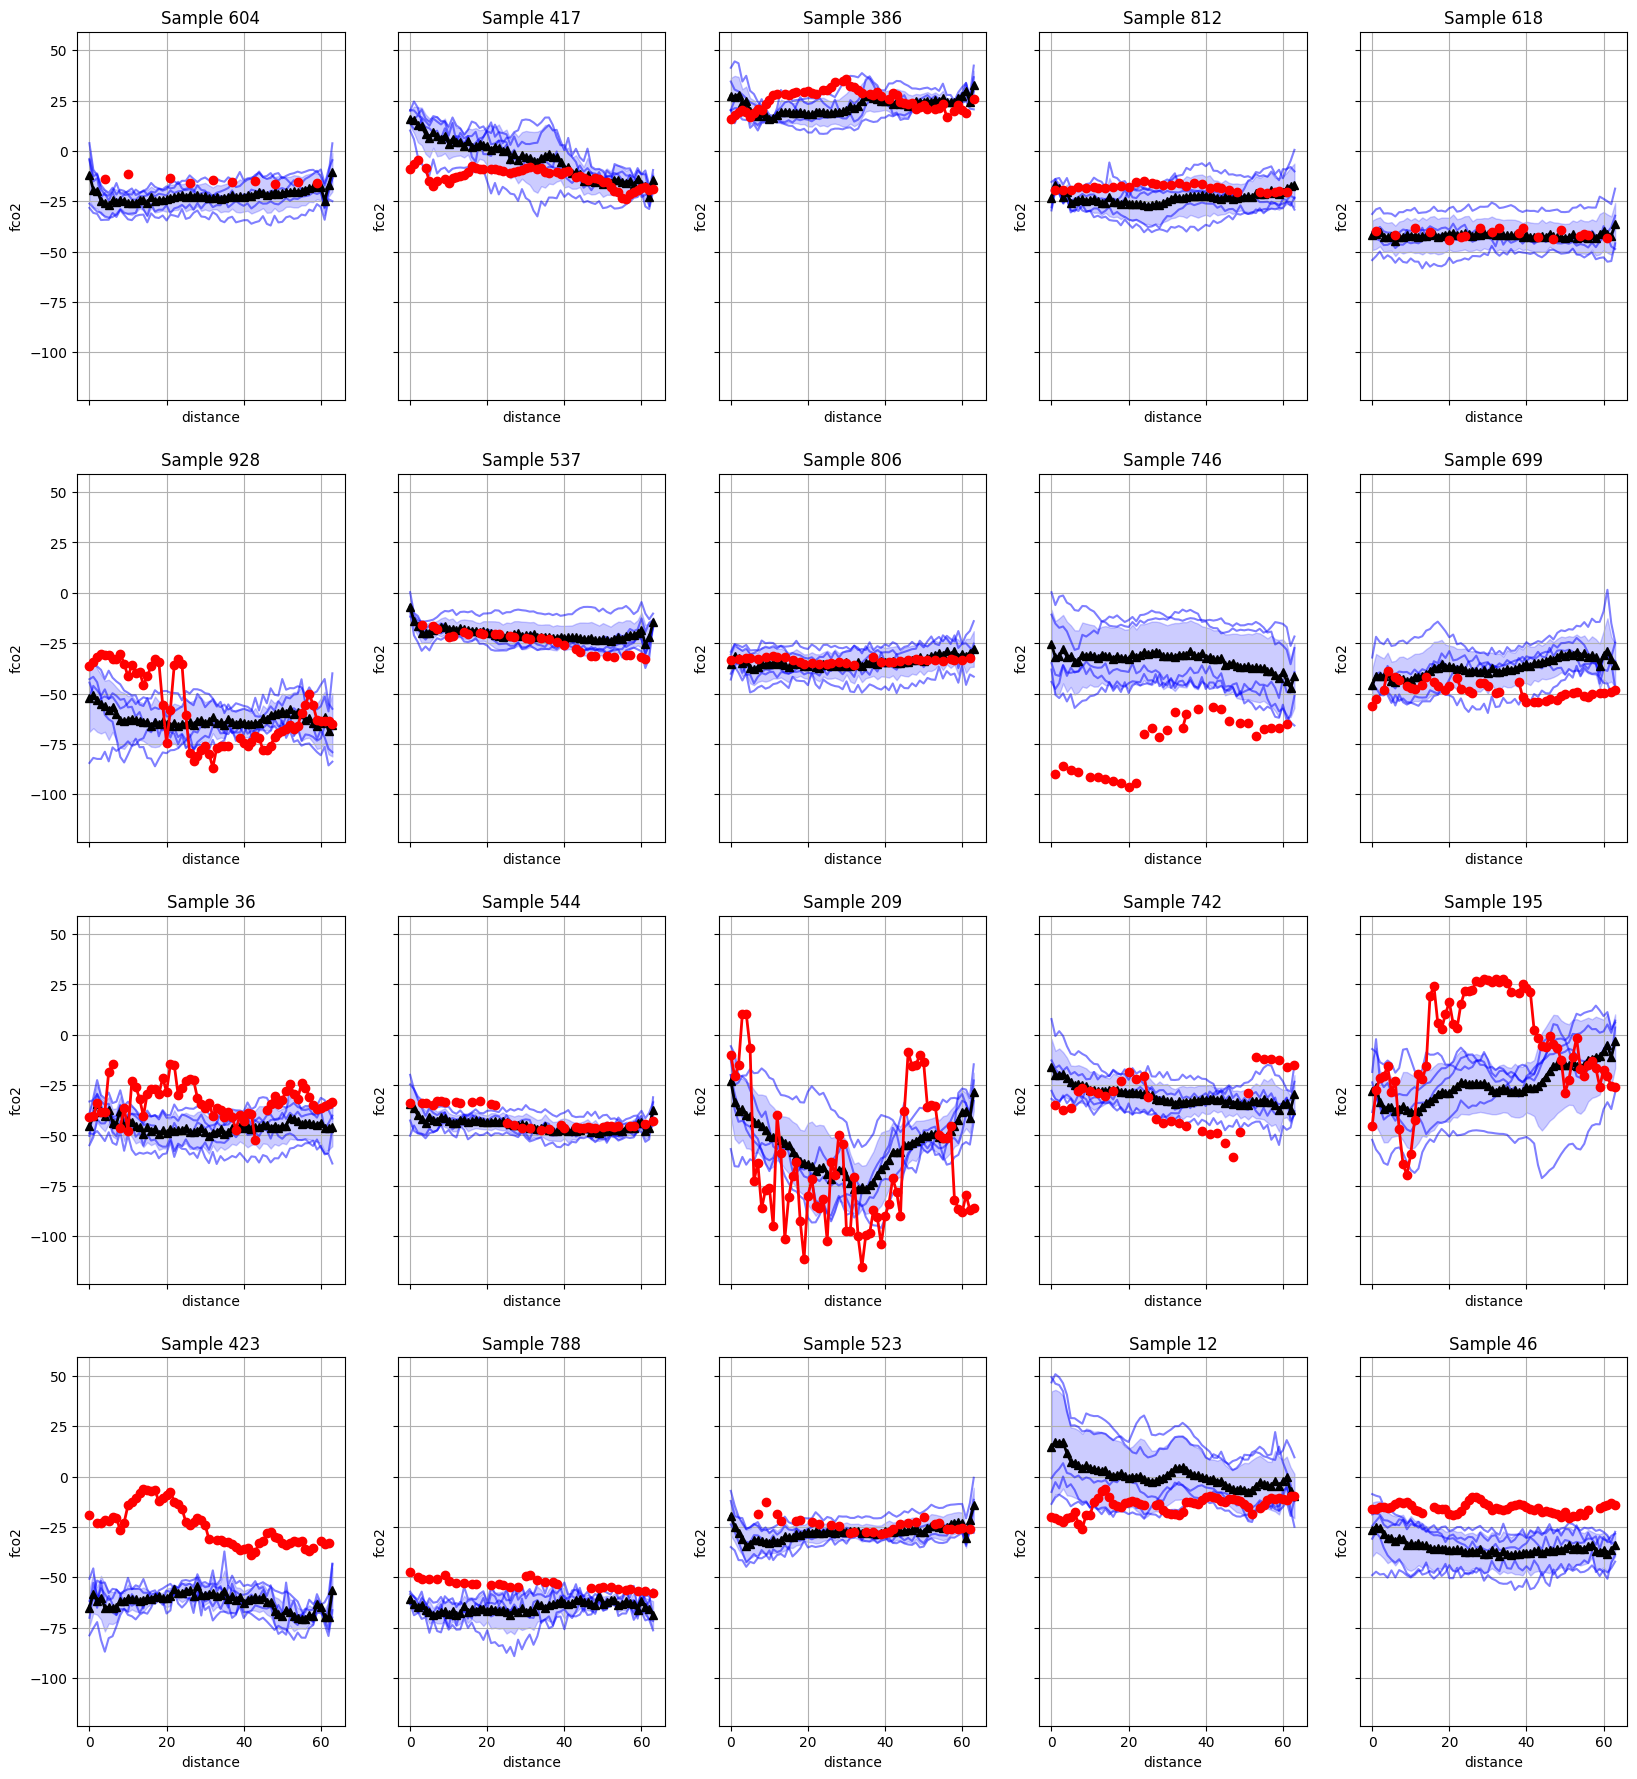

In [71]:
from fco2models.ueval import plot_samples
import matplotlib.pyplot as plt

ixs = np.random.choice(np.arange(0, n_samples), 22, replace=False)
fig, axs = plt.subplots(len(ixs) // 5, 5, figsize=(20, len(ixs)), sharex=True, sharey=True)
for i, ax in zip(ixs, axs.flatten()):
    samples = train_samples[i, :, :]
    truth = train_ds[i, 0, :]
    plot_samples(ax, samples, truth, title=f"Sample {i}")

plt.show()

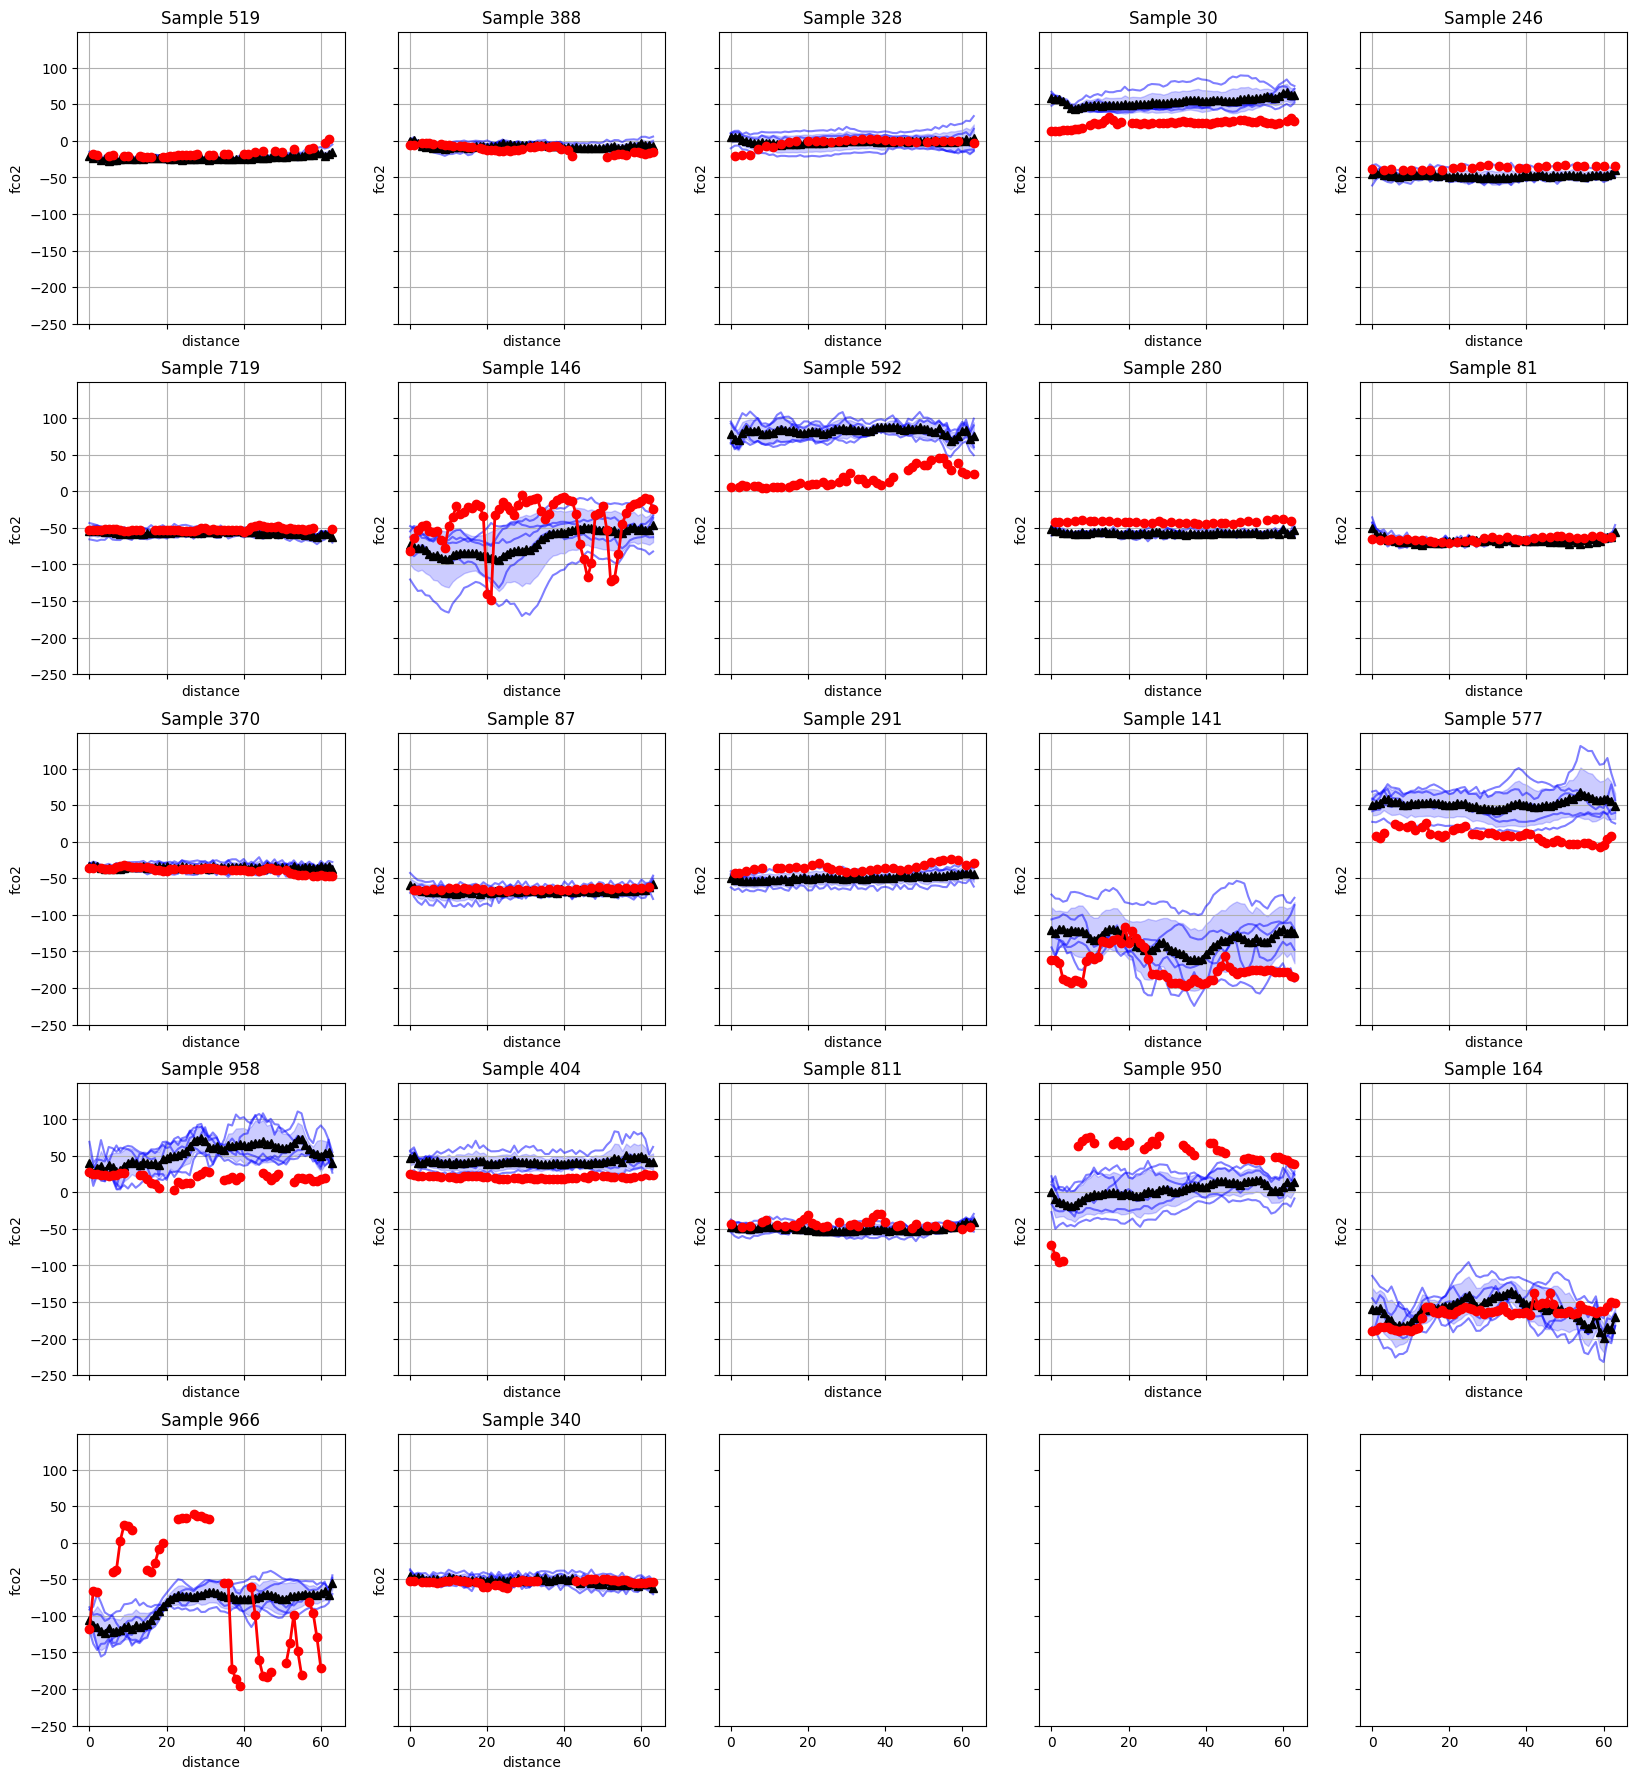

In [17]:
from fco2models.ueval import plot_samples
import matplotlib.pyplot as plt

ixs = np.random.choice(np.arange(0, n_samples), 22, replace=False)

fig, axs = plt.subplots(len(ixs)//5 + 1, 5, figsize=(20, len(ixs)), sharex=True, sharey=True)
for i, ax in zip(ixs, axs.flatten()):
    samples = val_samples[i, :, :]
    truth = val_ds[i, 0, :]
    plot_samples(ax, samples, truth, title=f"Sample {i}")

plt.show()

In [26]:
def get_info_df(preds, truth, coords, info):
    truth_preds_coords = np.concatenate((truth, preds, coords), axis=1)
    columns = ['fco2'] + [f'sample_{i}' for i in range(preds.shape[1])] + info
    truth_preds_coords_df = pd.DataFrame()
    for i, col in enumerate(columns):
        truth_preds_coords_df[col] = truth_preds_coords[:, i].flatten()
    return truth_preds_coords_df 

In [ ]:
info_df = get_info_df(
    np.concatenate([val_samples, train_samples], axis=0),
    np.concatenate([val_ds[:n_samples, 0:1, :], train_ds[:n_samples, 0:1, :]], axis=0),
    np.concatenate([val_coords[:n_samples], train_coords[:n_samples]], axis=0),
    info)

In [28]:
val_info_df.head()

,fco2,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,...,sample_15,sample_16,sample_17,sample_18,sample_19,lat,lon,day_of_year,year,expocode
0,NaN,133.566177,120.705688,111.980171,93.166092,120.726013,108.858971,141.052063,133.613678,125.104340,...,149.728424,154.808304,126.765221,157.414001,105.383141,10.665000,-125.195007,277.0,1997.0,430.0
1,-2.954742,137.945435,124.169533,113.250069,93.894295,123.519867,109.917641,142.328857,134.535690,128.263138,...,152.513885,160.137894,130.040726,160.774826,107.233223,10.623333,-125.206665,277.0,1997.0,430.0
2,NaN,137.957001,127.389275,114.841003,94.169815,116.368263,111.690224,143.388748,125.385185,126.108109,...,152.929916,163.240707,128.558380,160.368271,111.129753,10.585000,-125.220001,277.0,1997.0,430.0
3,0.283591,135.709549,124.250519,112.066589,94.077553,105.979271,111.685600,143.737808,117.453964,124.720757,...,152.109406,162.196793,123.666801,160.217331,112.864510,10.543334,-125.236679,277.0,1997.0,430.0
4,NaN,136.257004,127.408096,112.780357,96.412727,105.054840,111.072212,148.479568,109.499107,127.350929,...,152.688690,161.886185,120.724930,158.974411,116.628540,10.500000,-125.250000,277.0,1997.0,430.0


In [ ]:
def get_info_df(preds, truth, coords, info):
    truth_preds_coords = np.concatenate((truth, preds, coords), axis=1)
    columns = ['fco2'] + [f'sample_{i}' for i in range(preds.shape[1])] + info
    truth_preds_coords_df = pd.DataFrame()
    for i, col in enumerate(columns):
        truth_preds_coords_df[col] = truth_preds_coords[:, i].flatten()
    return truth_preds_coords_df 

In [ ]:
info_df = get_info_df(
    np.concatenate([val_samples, train_samples], axis=0),
    np.concatenate([val_ds[:, 0:1, :], train_ds[:, 0:1, :]], axis=0),
    np.concatenate([val_coords, train_coords], axis=0),
    info)

In [ ]:
group_cols = ['lat', 'lon']
info_df['predictions'] = info_df.iloc[:, 1:n_rec+1].mean(axis=1)
info_df['uncert'] = info_df.iloc[:, 1:n_rec+1].var(axis=1)
info_df['residuals'] = info_df['fco2'] - info_df['predictions']
# round group_cols to int
info_df[group_cols] = (info_df[group_cols] * 8).round(0) / 8.0
plotting_data = info_df.loc[:, group_cols + ['predictions', 'fco2', 'residuals', 'uncert']].groupby(group_cols).mean().to_xarray().coarsen(lat=10, lon=10, boundary='pad').mean()

(np.float64(-143.2542346954346),
 np.float64(-124.31986910502116),
 np.float64(-8.098683428764343),
 np.float64(10.592822321256001))

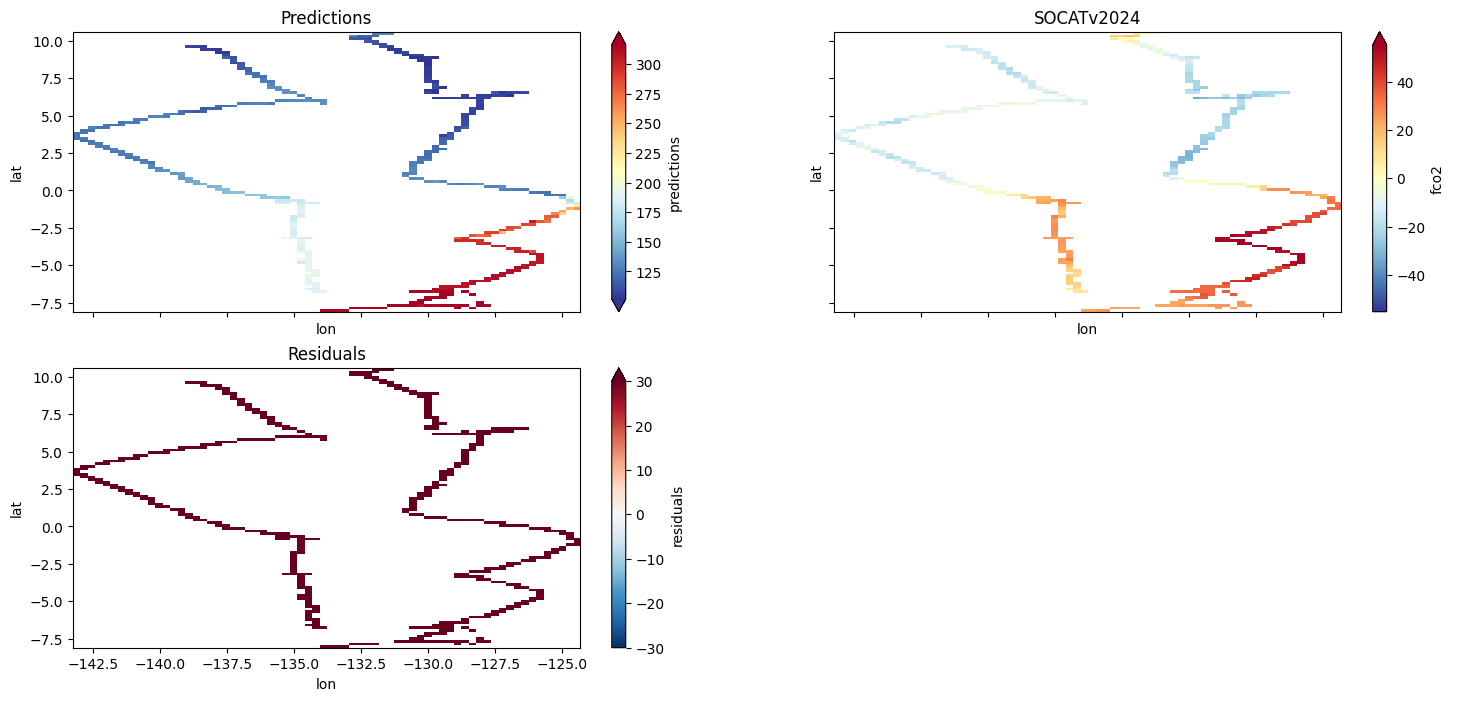

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(18, 8), sharex=True, sharey=True)
plotting_data.predictions.plot.imshow(robust=True, ax=axs[0, 0], cmap='RdYlBu_r',)
axs[0, 0].set_title('Predictions')
plotting_data.fco2.plot.imshow(robust=True, ax=axs[0, 1], cmap='RdYlBu_r')
axs[0, 1].set_title('SOCATv2024')
plotting_data.residuals.plot.imshow(robust=True, ax=axs[1, 0], cmap='RdBu_r', vmin=-30, vmax=30)
axs[1, 0].set_title('Residuals')
np.sqrt(plotting_data.uncert).plot.imshow(robust=True, ax=axs[1, 1], cmap='RdBu_r')
axs[1, 1].set_title('Variance ?')
plt.show()

In [50]:
expocodes = val_info_df.expocode.unique()
expocode = expocodes[0]
val_cruise = val_info_df[val_info_df.expocode == expocode]

In [52]:
val_info_df.year

0       1997.0
1       1997.0
2       1997.0
3       1997.0
4       1997.0
         ...  
3195    1997.0
3196    1997.0
3197    1997.0
3198    1997.0
3199    1997.0
Name: year, Length: 3200, dtype: float64

# analyse baseline model

In [59]:
import pandas as pd
import numpy as np
from fco2models.utraining import prep_df
val_df = pd.read_parquet('../data/training_data/valdf_100km_xco2.pq')
val_df2021 = pd.read_parquet('../data/training_data/df_100km_xco2_2021.pq')
train_df = pd.read_parquet('../data/training_data/traindf_100km_xco2.pq')

train_df, val_df, val_df2021 = prep_df([train_df, val_df, val_df2021], index=['segment', 'bin'], bound=True)

2025-05-03 19:23:50,549 - INFO - salinity stacking
2025-05-03 19:23:50,895 - INFO - adding positional and temporal encodings
2025-05-03 19:23:55,244 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-05-03 19:23:55,526 - INFO - add climatology data
2025-05-03 19:24:25,388 - INFO - replacing outliers with Nans, fco2rec_uatm > 400
2025-05-03 19:24:26,544 - INFO - salinity stacking
2025-05-03 19:24:26,576 - INFO - adding positional and temporal encodings
2025-05-03 19:24:26,958 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-05-03 19:24:26,998 - INFO - add climatology data
2025-05-03 19:24:40,822 - INFO - replacing outliers with Nans, fco2rec_uatm > 400
2025-05-03 19:24:40,955 - INFO - salinity stacking
2025-05-03 19:24:40,971 - INFO - adding positional and temporal encodings
2025-05-03 19:24:41,123 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-05-03 19:24:41,155 - INFO - add climatology data
2025-05-03 19:24:50,666 - INFO - replacing outlier

In [60]:
from fco2models.models import UNet2DModelWrapper, UNet1DModel
from fco2models.ueval import load_model
import torch
# load baseline model
save_path = '../models/baseline/naivepos/'
model_path = 'e_60.pt'
model_class = UNet2DModelWrapper
model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class)
print("Baseline model loaded")

Baseline model loaded


In [61]:
train_losses = losses['train_losses']
val_losses = losses['val_losses']
# print epoch with minimum loss
print("Epoch with minimum training loss: ", np.argmin(train_losses))
print("Minimum training loss: ", np.min(train_losses))

print("Epoch with minimum validation loss: ", np.argmin(val_losses))
print("Minimum validation loss: ", np.min(val_losses))

Epoch with minimum training loss:  99
Minimum training loss:  0.09788767590863781
Epoch with minimum validation loss:  36
Minimum validation loss:  0.21699580298313362


In [62]:
from fco2models.utraining import prepare_segment_ds, normalize_dss, get_stats
predictors = params['predictors']
info = ['lat', 'lon', 'day_of_year', 'year', 'expocode']
(train_ds, train_coords), (val_ds, val_coords) = prepare_segment_ds([train_df, val_df], predictors, with_mask=True, info=info)
train_stats = get_stats(train_ds)
np.random.shuffle(val_ds)
train_ds_norm, val_ds_norm = normalize_dss([train_ds.copy(), val_ds.copy()], train_stats, params['mode'], ignore=[7, 8, 9, 10, 11, 12])
stats = {'train_means': train_stats['means'], 
         'train_stds': train_stats['stds'],
         'train_mins': train_stats['mins'], 
         'train_maxs': train_stats['maxs']
         }
# vald_ds2021 = prep_data(vald_df2021, predictors)
# val_ds = np.concatenate((val_ds, vald_ds2021), axis=0)

print("train_ds shape: ", train_ds.shape)
print("val_ds shape: ", val_ds.shape)

2025-05-03 19:24:51,142 - INFO - info features: ['lat', 'lon', 'day_of_year', 'year', 'expocode']
2025-05-03 19:24:54,564 - INFO - predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'xco2', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat', 'sin_lon_cos_lat', 'cos_lon_cos_lat']


Number of samples after filtering:  209343
yX shape: (12, 209343, 64)


2025-05-03 19:25:02,047 - INFO - predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'xco2', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat', 'sin_lon_cos_lat', 'cos_lon_cos_lat']


Number of samples after filtering:  22441
yX shape: (12, 22441, 64)


2025-05-03 19:25:07,532 - INFO - Means: [np.float64(-31.85515019522005), np.float64(291.49492360826207), np.float64(32.558164963890555), np.float64(0.6836796394383253), np.float64(0.05670852774367465), np.float64(37.11385439700527), np.float64(392.4558850338762), np.float64(0.6470912102728014), np.float64(0.02198655885396615), np.float64(0.2753931007614051), np.float64(-0.16399171357166006), np.float64(0.07971597452035714), np.float64(0.8040780411812194)]
2025-05-03 19:25:07,532 - INFO - Stds: [np.float64(55.44230006579691), np.float64(9.417746927771578), np.float64(7.516368452649472), np.float64(1.8752586802383828), np.float64(0.10902147425141874), np.float64(56.17053871096368), np.float64(13.507788179586058), np.float64(0.2978493992686017), np.float64(0.7014807879549392), np.float64(0.5414473433774956), np.float64(0.4989884100091686), np.float64(0.5905557233560285), np.float64(0.3969087361993846)]
2025-05-03 19:25:07,532 - INFO - Mins: [np.float64(-391.4479064941406), np.float64(271.

train_ds shape:  (209343, 13, 64)
val_ds shape:  (22441, 13, 64)


In [63]:
assert np.allclose(train_stats['maxs'], params['train_maxs'])
assert np.allclose(train_stats['mins'], params['train_mins'])
assert np.allclose(train_stats['means'], params['train_means'])
assert np.allclose(train_stats['stds'], params['train_stds'])

In [64]:
n_samples = val_ds_norm.shape[0]

In [ ]:
def wrap_and_eval_mean_estimator(s, model, n_samples=50):
    from torch.utils.data import DataLoader, TensorDataset
    from fco2models.umeanest import predict_mean_eval
    if n_samples == None:
        n_samples = s.shape[0]
    s_context = s[:n_samples]
    print("context_ds shape: ", s_context.shape)
    s_context_ds = TensorDataset(torch.from_numpy(s_context).float())
    
    s_context_loader = DataLoader(s_context_ds, batch_size=256, shuffle=False)
    
    with torch.no_grad():
        # denoise the samples
        print("Estimating mean samples")
        losses, s_means_norm = predict_mean_eval(model, s_context_loader)
    return s_means_norm, losses
    

In [ ]:
val_means_norm, val_losses = wrap_and_eval_mean_estimator(val_ds_norm, model, n_samples=None)

context_ds shape:  (22441, 13, 64)
Estimating mean samples
Predicting on cuda


Predicting: 100%|██████████| 88/88 [00:09<00:00,  9.58it/s, Loss=nan]


In [94]:
train_means_norm, train_losses = wrap_and_eval_mean_estimator(train_ds_norm, model, n_samples=None)

context_ds shape:  (209343, 13, 64)
Estimating mean samples
Predicting on cuda


Predicting: 100%|██████████| 818/818 [01:23<00:00,  9.75it/s, Loss=nan]


In [68]:
val_means_norm.shape

(22441, 1, 64)

In [95]:
from fco2models.ueval import get_error_stats, rescale
# calculate the error statistics for the validation set
print("Validation set error stats")
val_means = rescale(
    val_means_norm.copy(), stats, params['mode']
    ).reshape(val_means_norm.shape)
# val_ds_scaled = rescale(
#     val_ds.copy(), stats, params['mode']
#     ).reshape(val_ds.shape)
val_error_dict = get_error_stats(
    val_means, 
    val_ds[:n_samples, 0:1, :]
    )

Validation set error stats
Error statistics:
RMSE: 27.7383
MAE: 16.0325
R2: 0.7363
Bias: -0.2340 ± 21.1543
Mean correlation: 0.2388 ± 0.4617


In [97]:
from fco2models.ueval import get_error_stats, rescale
# get error stats for the training set
print("Training set error stats")
train_means = rescale(
    train_means_norm.copy(), stats, params['mode']
    ).reshape(train_means_norm.shape)
train_error_dict = get_error_stats(
    train_means, 
    train_ds[:, 0:1, :]
    )

Training set error stats
Error statistics:
RMSE: 17.5863
MAE: 11.2075
R2: 0.8994
Bias: -0.3116 ± 10.9017
Mean correlation: 0.3118 ± 0.4434


In [98]:
import matplotlib.pyplot as plt
def plot_preds(preds, ds, ixs, random_preds=None):
    fig, axs = plt.subplots(len(ixs), 1, sharex=True, sharey=True, figsize=(20,len(ixs) * 5))
    for (i, ix) in enumerate(ixs):
        axs[i].plot(preds[ix, 0, :].T, '^-', label='prediction', color='blue', alpha=0.5, linewidth=2)
        axs[i].plot(ds[ix, 0, :].T, 'o-', label='original', color='red', alpha=1, linewidth=2)
        if random_preds is not None:
            axs[i].plot(random_preds[ix, 0, :].T, 'o-', label='random prediction', color='green', alpha=0.5)
        axs[i].set_title(f'Prediction vs original {ix}')
        axs[i].set_xlabel('bins')
        axs[i].set_ylabel('fCO2')

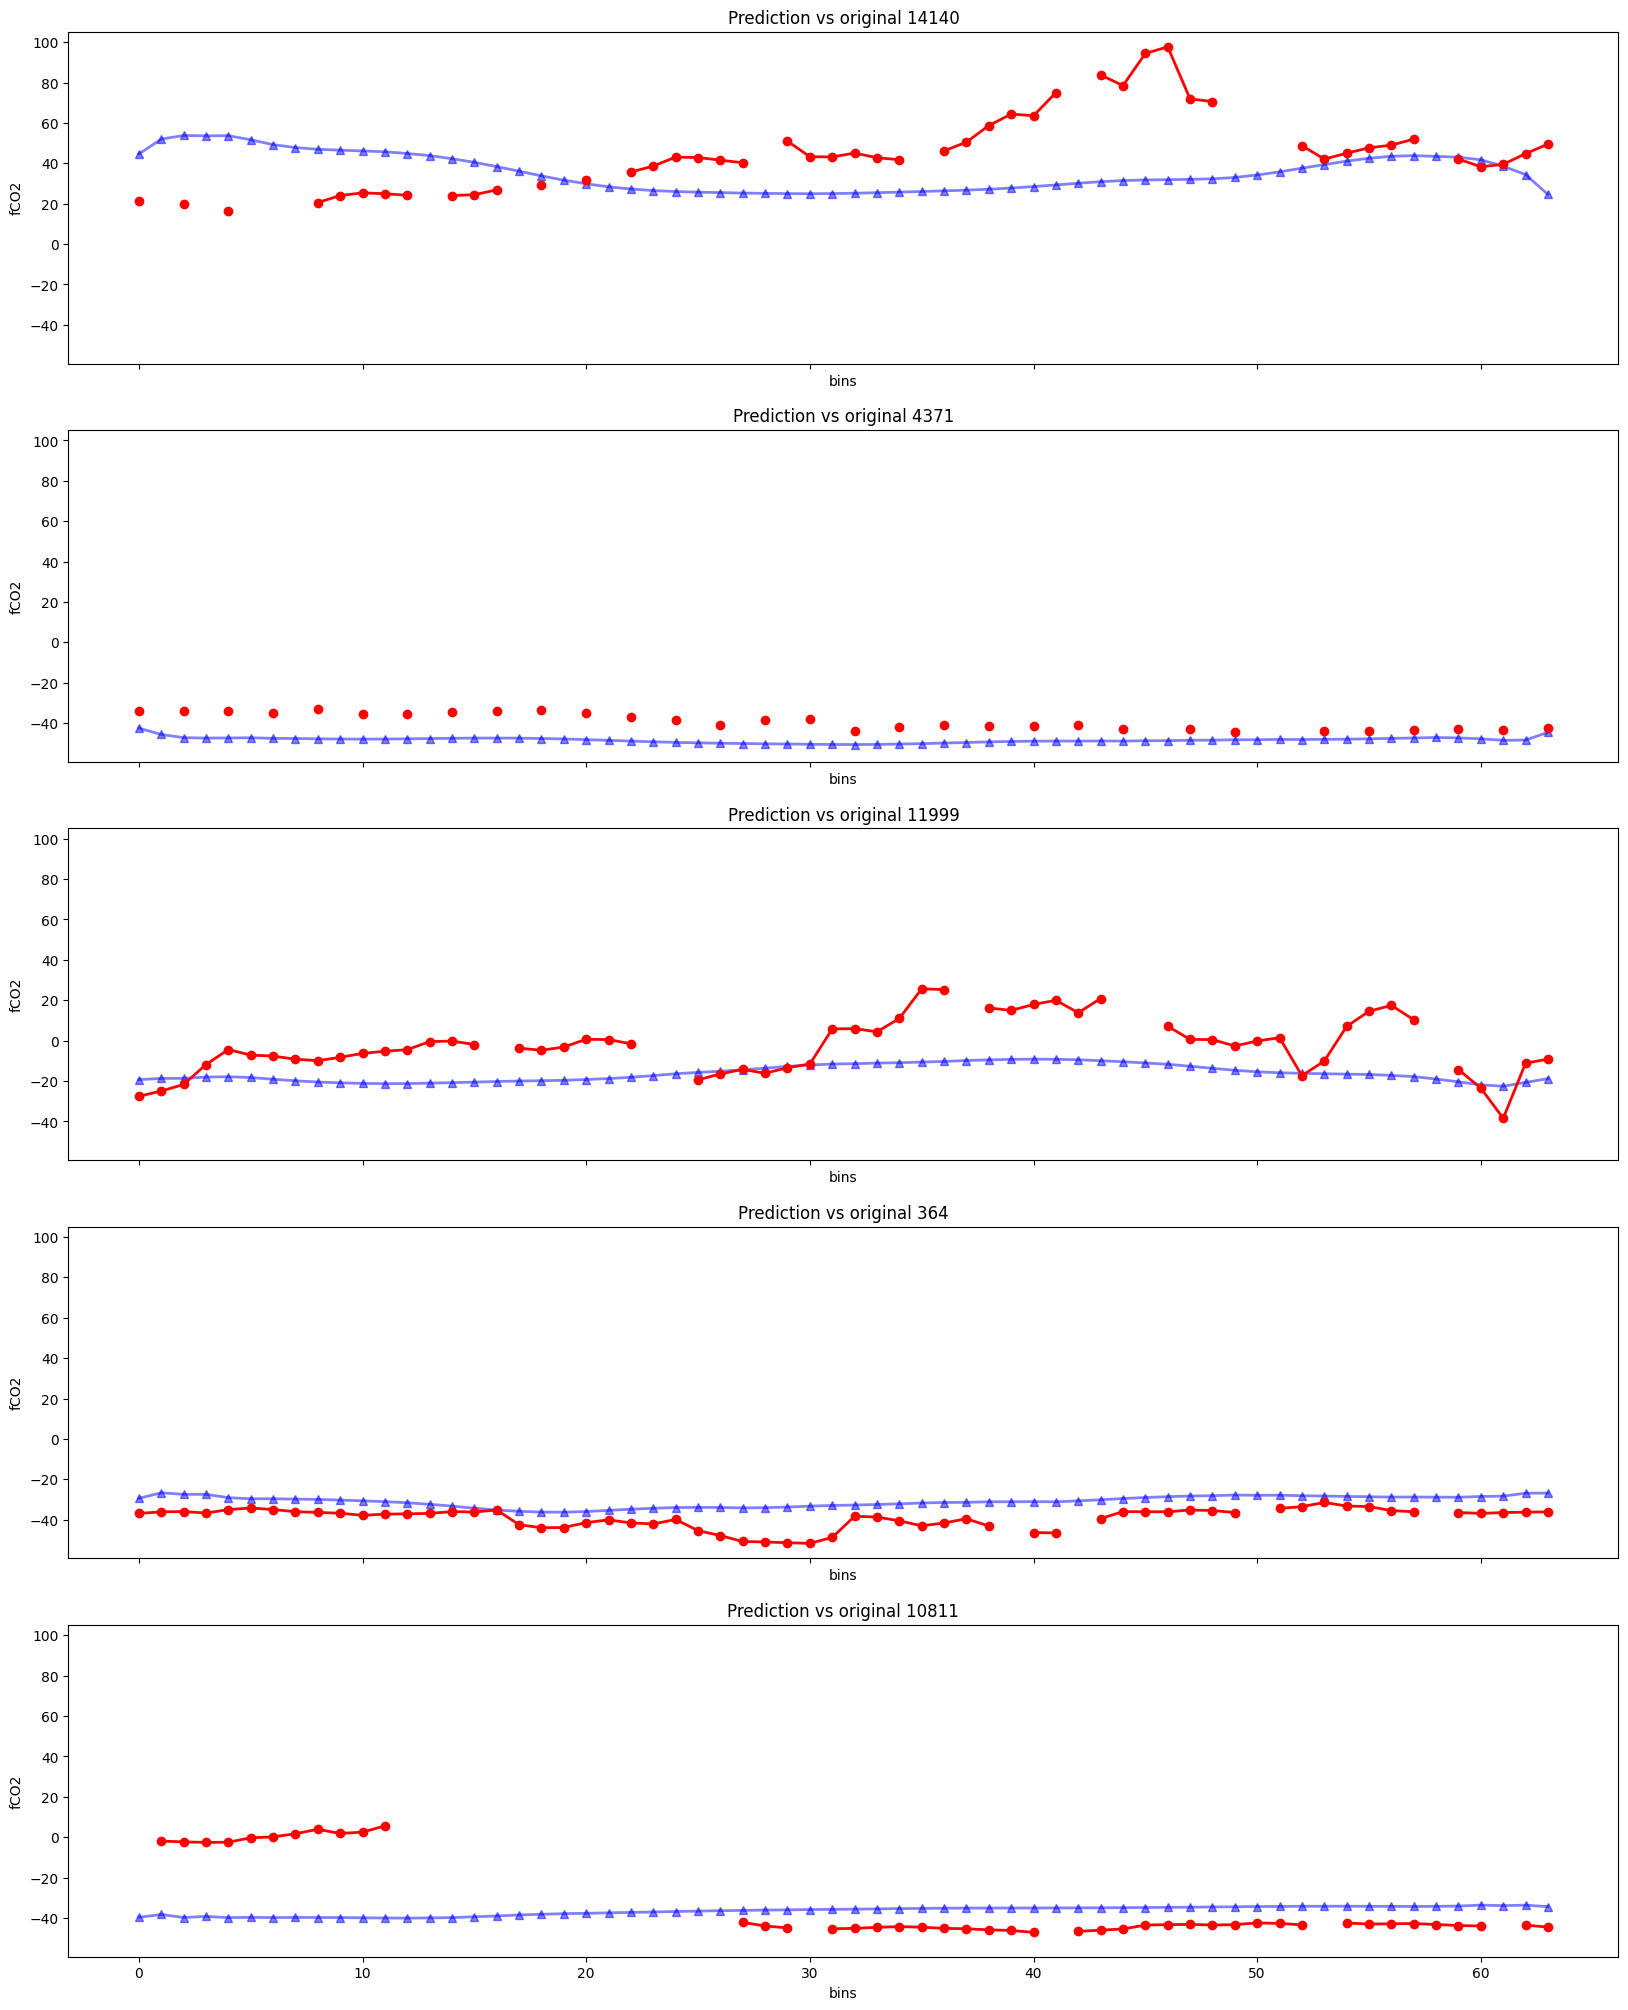

In [99]:
plot_preds(train_means, train_ds[:n_samples], np.random.choice(np.arange(n_samples), size=5, replace=False))

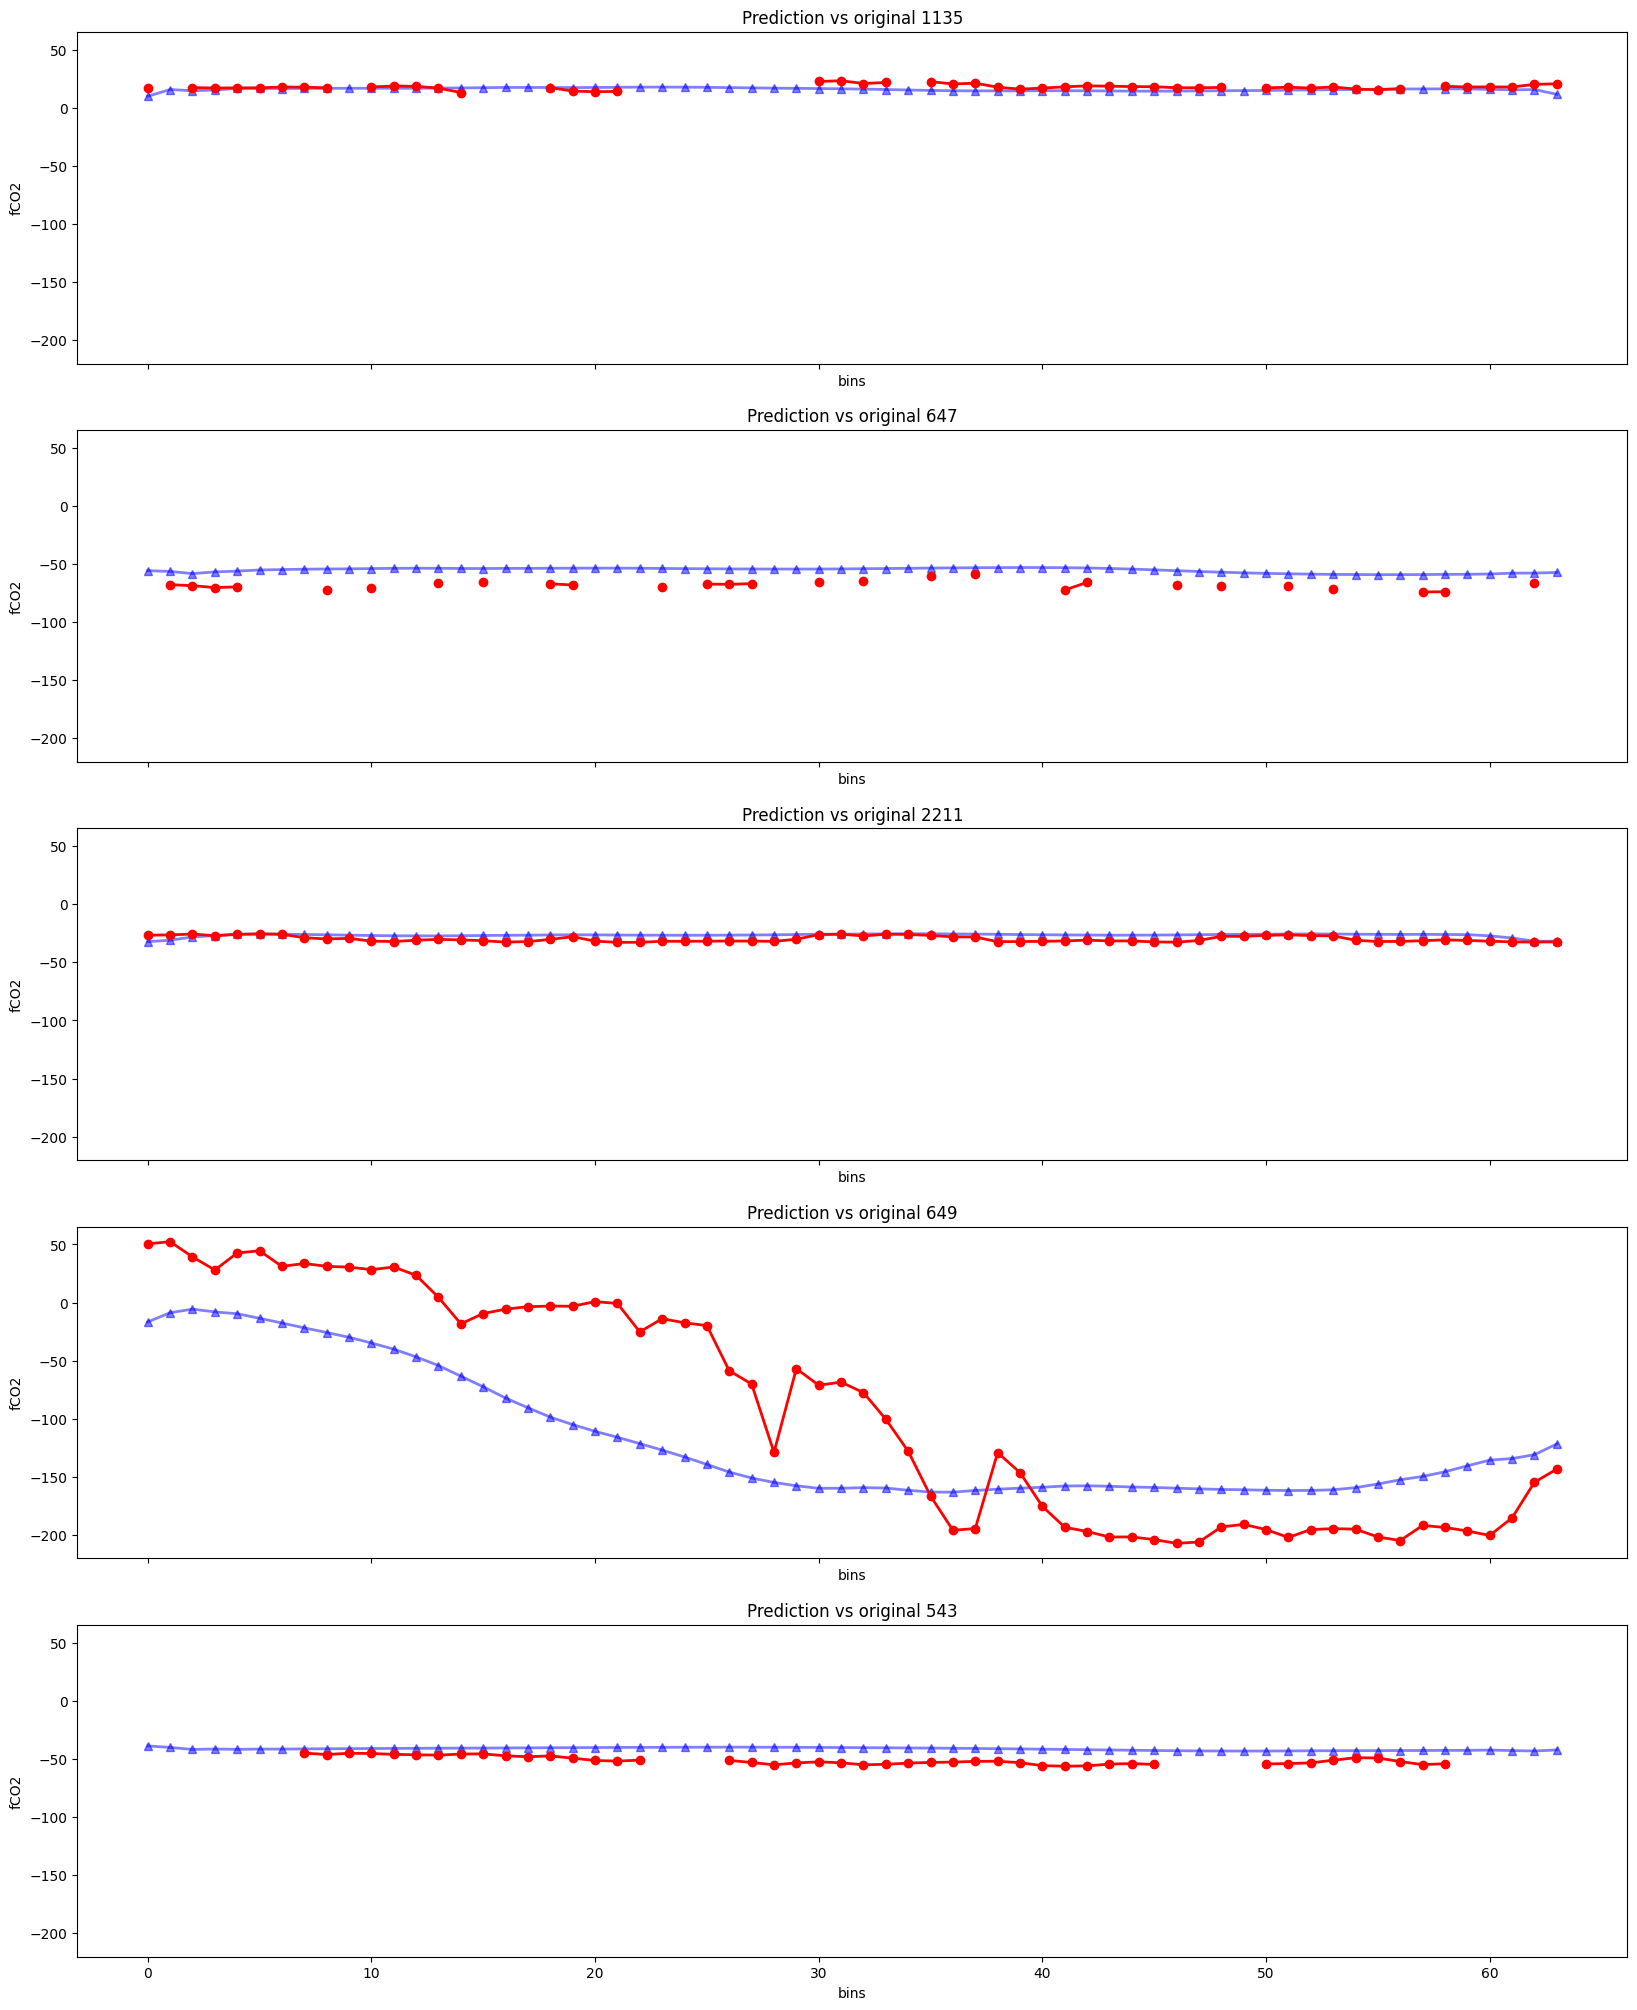

In [100]:
plot_preds(val_means, val_ds[:3000], np.random.choice(np.arange(3000), size=5, replace=False))

In [101]:
def get_info_df(preds, truth, coords, info):
    truth_preds_coords = np.concatenate((truth, preds, coords), axis=1)
    columns = ['fco2'] + [f'sample_{i}' for i in range(preds.shape[1])] + info
    truth_preds_coords_df = pd.DataFrame()
    for i, col in enumerate(columns):
        truth_preds_coords_df[col] = truth_preds_coords[:, i].flatten()
    return truth_preds_coords_df 

In [102]:
np.concatenate([val_means, train_means], axis=0).shape

(231784, 1, 64)

In [120]:
info = ['lat', 'lon', 'day_of_year', 'year', 'expocode']
info_df = get_info_df(
    np.concatenate([val_means, train_means], axis=0),
    np.concatenate([val_ds[:, 0:1, :], train_ds[:, 0:1, :]], axis=0),
    np.concatenate([val_coords, train_coords], axis=0),
    info)

In [121]:
info_df.head()

,fco2,sample_0,lat,lon,day_of_year,year,expocode
0,NaN,34.014584,10.665000,-125.195007,277.0,1997.0,430.0
1,26.631178,30.642115,10.623333,-125.206665,277.0,1997.0,430.0
2,26.800179,28.562391,10.585000,-125.220001,277.0,1997.0,430.0
3,27.555845,27.438208,10.543334,-125.236679,277.0,1997.0,430.0
4,28.614677,26.830507,10.500000,-125.250000,277.0,1997.0,430.0


In [124]:
group_cols = ['lat', 'lon']
info_df['predictions'] = info_df.iloc[:, 1]
info_df['residuals'] = info_df['predictions'] - info_df['fco2']
# round group_cols to int
info_df[group_cols] = (info_df[group_cols] * 8).round(0) / 8.0
plotting_data = info_df.loc[:, group_cols + ['predictions', 'fco2', 'residuals']].groupby(group_cols).mean().to_xarray().coarsen(lat=10, lon=10, boundary='pad').mean()

(np.float64(-180.0625),
 np.float64(180.625),
 np.float64(-78.5625),
 np.float64(82.4375))

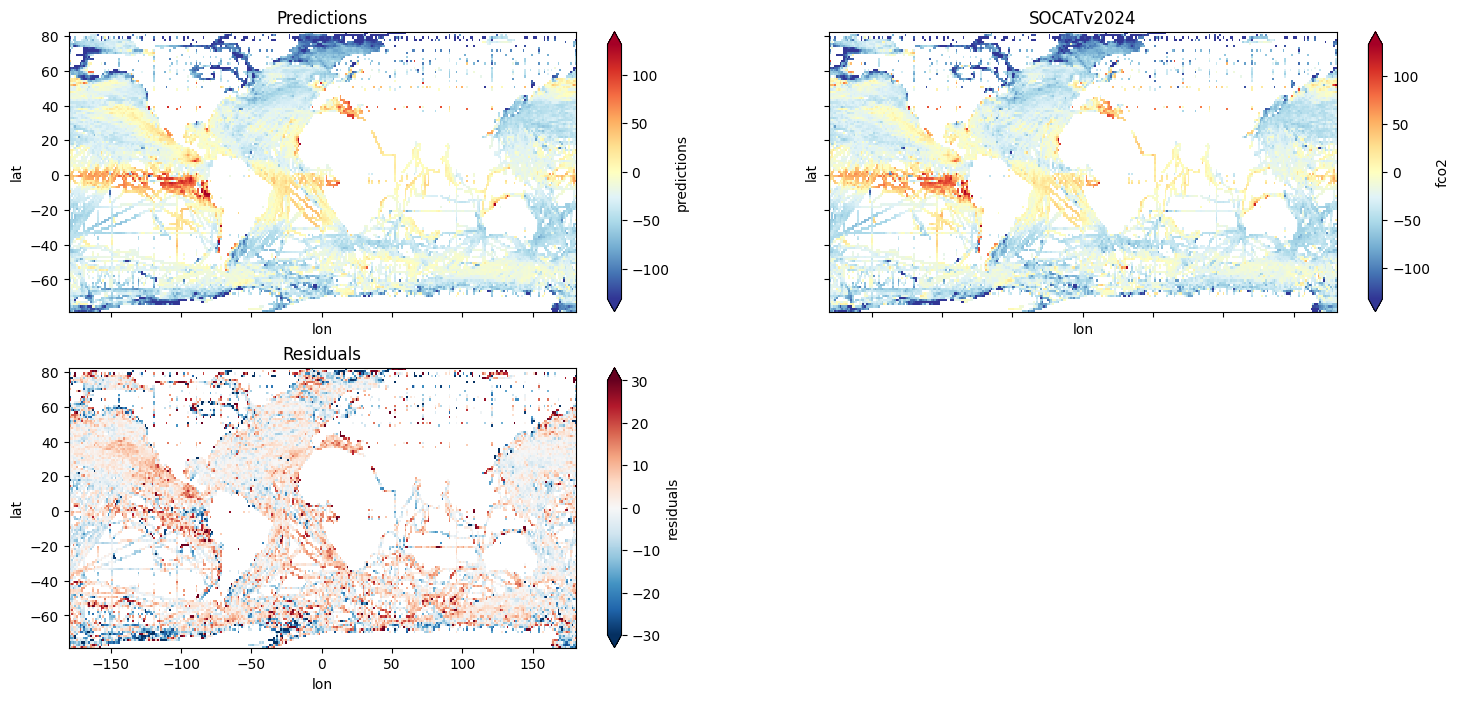

In [125]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(18, 8), sharex=True, sharey=True)
plotting_data.predictions.plot.imshow(robust=True, ax=axs[0, 0], cmap='RdYlBu_r',)
axs[0, 0].set_title('Predictions')
plotting_data.fco2.plot.imshow(robust=True, ax=axs[0, 1], cmap='RdYlBu_r')
axs[0, 1].set_title('SOCATv2024')
plotting_data.residuals.plot.imshow(robust=True, ax=axs[1, 0], cmap='RdBu_r', vmin=-30, vmax=30)
axs[1, 0].set_title('Residuals')
axs[1, 1].axis('off')